In [6]:
import fiftyone as fo
import datetime as dt
import os
import time


dataset = fo.load_dataset('RumexWeeds')
print(dataset)

Name:        RumexWeeds
Media type:  image
Num samples: 5510
Persistent:  True
Tags:        ['20210806_hegnstrup_seq0', '20210806_hegnstrup_seq1', '20210806_hegnstrup_seq10', '20210806_hegnstrup_seq11', '20210806_hegnstrup_seq12', '20210806_hegnstrup_seq13', '20210806_hegnstrup_seq14', '20210806_hegnstrup_seq15', '20210806_hegnstrup_seq16', '20210806_hegnstrup_seq17', '20210806_hegnstrup_seq2', '20210806_hegnstrup_seq3', '20210806_hegnstrup_seq4', '20210806_hegnstrup_seq5', '20210806_hegnstrup_seq6', '20210806_hegnstrup_seq7', '20210806_hegnstrup_seq8', '20210806_hegnstrup_seq9', '20210806_stengard_seq0', '20210806_stengard_seq1', '20210806_stengard_seq10', '20210806_stengard_seq11', '20210806_stengard_seq12', '20210806_stengard_seq13', '20210806_stengard_seq14', '20210806_stengard_seq15', '20210806_stengard_seq16', '20210806_stengard_seq17', '20210806_stengard_seq18', '20210806_stengard_seq19', '20210806_stengard_seq2', '20210806_stengard_seq20', '20210806_stengard_seq3', '20210806_st

In [7]:
with fo.ProgressBar() as pb:
    for sample in pb(dataset):
        unixtime_str = os.path.splitext(os.path.split(sample.filepath)[-1])[0].split('_')[-1]
        sample['created_at'] = dt.datetime(*list(time.gmtime(float(unixtime_str)*1e-9)[0:6]))
        sample.save()


 100% |███████████████| 5510/5510 [6.0m elapsed, 0s remaining, 37.7 samples/s]      


In [8]:
session = fo.Session(auto=False, dataset=dataset)

In [9]:
summer_view = dataset.match(fo.ViewField("created_at").month() >= 6).match(fo.ViewField("created_at").month() <= 8)
summer_view.tag_samples("summer")

In [10]:
session.view = summer_view

In [11]:
autumn_view = dataset.match(fo.ViewField("created_at").month() >= 9).match(fo.ViewField("created_at").month() <= 11)
autumn_view.tag_samples("autumn")

In [12]:
from fiftyone import ViewField as F
bbox_width = F("bounding_box")[2] #* F("$metadata.width")
bbox_height = F("bounding_box")[3] #* F("$metadata.height")
bbox_area = bbox_width * bbox_height * 100

In [13]:
gt_areas = F("ground_truth_detections.detections[]").apply(bbox_area)
print(autumn_view.mean(gt_areas))
print(summer_view.mean(gt_areas))


2.3420427312077705
2.666648217707653


In [20]:
plot1 = fo.NumericalHistogram(gt_areas, bins=500, init_view=summer_view, xlabel='BB area in % of total image pixels (summer)')
plot1.ylabel = 'count'
#plot1.show()
plot2 = fo.NumericalHistogram(gt_areas, bins=500, init_view=autumn_view, xlabel='BB area in % of total image pixels (autumn)')
plot2.ylabel = 'count'
plot = fo.ViewGrid([plot1, plot2])
plot.show()

FigureWidget({
    'data': [{'customdata': array([[ 0.05924479,  0.13970113],
                                …

Text(0.5, 0, '% of total image pixels')

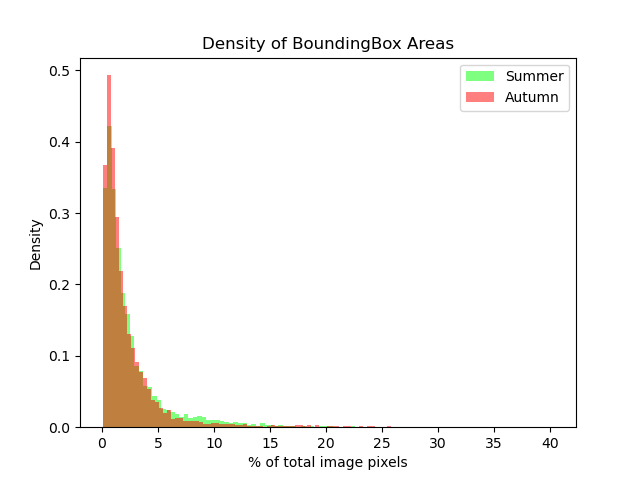

In [21]:
import matplotlib.pyplot as plt
%matplotlib widget
fig = plt.hist(summer_view.values(gt_areas), bins=100, density=True, fc=(0, 1, 0, 0.5), label="Summer")
fig = plt.hist(autumn_view.values(gt_areas), bins=100, density=True, fc=(1, 0, 0, 0.5), label="Autumn")
plt.legend()
plt.title('Density of BoundingBox Areas')
plt.ylabel('Density')
plt.xlabel('% of total image pixels')

In [22]:
import scipy.stats
scipy.stats.ttest_ind(summer_view.values(gt_areas), autumn_view.values(gt_areas))

Ttest_indResult(statistic=5.934434251940654, pvalue=3.011399004413868e-09)